In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence

In [2]:
data = pd.read_csv('Fraud_data/Fraud_Data.csv', parse_dates = ['signup_time', 'purchase_time'])
data.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
adr2con = pd.read_csv('Fraud_data/IpAddress_to_Country.csv')
adr2con.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [4]:
#Add County to the dataset
country =[]
for i in range(len(data)):
    ip_address = data.loc[i,'ip_address']
    tmp = adr2con[(adr2con['lower_bound_ip_address'] <= ip_address) &
                  (adr2con['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        country.append(tmp['country'].values[0])
    else:
        country.append('NA')
data['country'] = country
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


* Time difference btw signup and purchase. --> time_diff
* Certain users with same device? --> device_num 
* Certain users with same ip address? -->ip_num 
* Day of week sign up -->signup_day
* Week of year sign up --> signup_week
* Day of week purchase -->purchase_day
* Week of year purchase --> purchase_week

In [5]:
#time_diff
time_diff = data['purchase_time'] - data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff

In [6]:
#device_num
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns = {'user_id': 'device_num'})
data = data.merge(device_num, how = 'left', on = 'device_id')
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1


In [7]:
#ip_num
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns = {'user_id': 'ip_num'})
data = data.merge(ip_num, how = 'left', on = 'ip_address')

In [8]:
#signup day of week, week of year
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

#purchase day of week, week of year
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [9]:
#Features used in the model
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
data = data[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


In [10]:
#Categorical Feature Encoding: source,browser,sex,country
lb = LabelEncoder()
data['source_lb'] = lb.fit_transform(data['source'])
data['browser_lb'] = lb.fit_transform(data['browser'])
data['sex_lb'] = lb.fit_transform(data['sex'])
data['country_lb'] = lb.fit_transform(data['country'])
data[['source_lb', 'source']].head(5)


,source_lb,source
0,2,SEO
1,0,Ads
2,2,SEO
3,2,SEO
4,0,Ads


In [11]:
lb_columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source_lb', 'browser_lb', 'sex_lb', 'age', 'country_lb', 'time_diff', 'device_num', 'ip_num', 'class']
data_lb = data[lb_columns]
data_lb.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source_lb,browser_lb,sex_lb,age,country_lb,time_diff,device_num,ip_num,class
0,1,9,5,16,34,2,0,1,39,84,13882,1,1,0
1,6,23,0,24,16,0,0,0,53,172,17944,1,1,0
2,3,1,3,1,15,2,3,1,53,172,1,12,12,1
3,1,18,0,19,44,2,4,1,41,115,60085,1,1,0
4,1,30,2,37,39,0,4,1,45,172,41461,1,1,0


In [12]:
#Split 70% training set
y = data_lb['class']
X_train, X_test, y_train, y_test = train_test_split(data_lb.iloc[:,:-1], y, random_state = 42, test_size = 0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(105778, 13) (105778,)
(45334, 13) (45334,)


In [32]:
#Random Forest Model
rf = RandomForestRegressor(n_estimators = 10, oob_score = True, random_state = 42, max_depth = 15, min_samples_split = 3)
rf.fit(X_train, y_train)

C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [33]:
y_pred = rf.predict(X_train)
y_test_pre = rf.predict(X_test)
print ('AUC Score(Train):')
print(roc_auc_score(y_train, y_pred))
print('AUC Score(Test):')
print(roc_auc_score(y_test, y_test_pre))

AUC Score(Train):
0.9533808045037484
AUC Score(Test):
0.8435048496257771


In [15]:
#Adjust Model Params for better fit 
#n-estimator
param_test1 = {'n_estimators': range(10,71,10)}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(oob_score = True, min_samples_split= 5, max_depth=10, random_state=42, min_samples_leaf = 40), 
                        param_grid = param_test1, scoring = 'roc_auc',cv=5)
gsearch1.fit(X_train,y_train)


C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OO

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=40, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(10, 71, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [16]:
res_df = pd.DataFrame(gsearch1.cv_results_)[['mean_train_score','std_train_score', 'params']]
print('Train param of n_estimators:')
res_df, gsearch1.best_params_, gsearch1.best_score_

Train param of n_estimators:


(   mean_train_score  std_train_score                params
 0          0.901359         0.001129  {'n_estimators': 10}
 1          0.911452         0.002221  {'n_estimators': 20}
 2          0.917447         0.002393  {'n_estimators': 30}
 3          0.921537         0.002521  {'n_estimators': 40}
 4          0.923697         0.001496  {'n_estimators': 50}
 5          0.925543         0.001674  {'n_estimators': 60}
 6          0.927171         0.001831  {'n_estimators': 70},
 {'n_estimators': 10},
 0.8422054732347998)

In [17]:
#max_depth & min_samples_split
param_test2 = {'max_depth': range(5,31,5), 'min_samples_split': range(3,9,2)}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators = 40,oob_score = True, random_state = 42, min_samples_leaf = 40),
                       param_grid = param_test2, scoring = 'roc_auc', cv = 5)
gsearch2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=40, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(5, 31, 5), 'min_samples_split': range(3, 9, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [18]:
res_df2 = pd.DataFrame(gsearch2.cv_results_)[['mean_train_score','std_train_score', 'params']]
print('Train param of max_depth & min_samples_split:')
res_df2, gsearch2.best_params_, gsearch2.best_score_

Train param of max_depth & min_samples_split:


(    mean_train_score  std_train_score  \
 0           0.863160         0.001533   
 1           0.863160         0.001533   
 2           0.863160         0.001533   
 3           0.921537         0.002521   
 4           0.921537         0.002521   
 5           0.921537         0.002521   
 6           0.962061         0.001735   
 7           0.962061         0.001735   
 8           0.962061         0.001735   
 9           0.973503         0.000911   
 10          0.973503         0.000911   
 11          0.973503         0.000911   
 12          0.975784         0.000471   
 13          0.975784         0.000471   
 14          0.975784         0.000471   
 15          0.976171         0.000323   
 16          0.976171         0.000323   
 17          0.976171         0.000323   
 
                                        params  
 0    {'max_depth': 5, 'min_samples_split': 3}  
 1    {'max_depth': 5, 'min_samples_split': 5}  
 2    {'max_depth': 5, 'min_samples_split': 7}  
 3  

In [34]:
features = list(X_train.columns)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
ipt = sorted(zip(features, importances), key = lambda x: x[1], reverse = True)
print('Feature Importance Ranking:')
for f,val in ipt:
    print('{0:10s} | {1:.5f}'.format(f, val))


Feature Importance Ranking:
time_diff  | 0.81274
device_num | 0.04684
purchase_value | 0.02459
age        | 0.02203
purchase_week | 0.02006
signup_week | 0.01828
country_lb | 0.01515
signup_day | 0.01109
purchase_day | 0.01072
browser_lb | 0.00760
source_lb  | 0.00646
sex_lb     | 0.00306
ip_num     | 0.00137


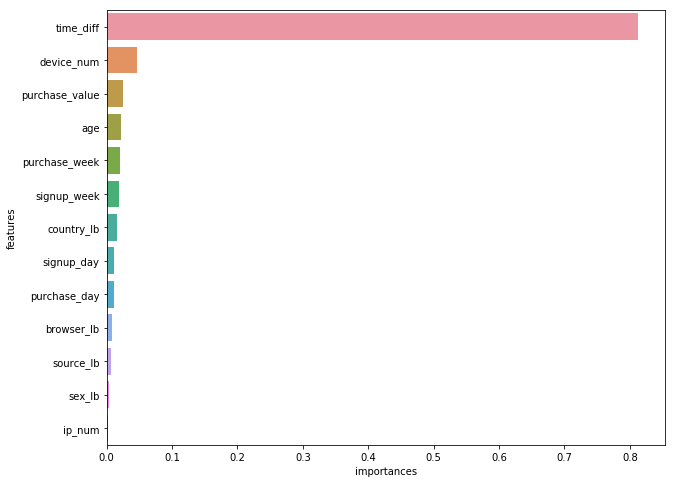

In [35]:
#plot feature importances
plt_ipt = pd.DataFrame(data = ipt, columns =['features', 'importances'])
fig, ax = plt.subplots(figsize = (10,8))
sns.barplot(x = 'importances', y = 'features', data = plt_ipt)
plt.show()


In [38]:
#Prediction
train_pre = rf.predict(X_train)
test_pre = rf.predict(X_test)

train_fpr, train_tpr, _ = roc_curve(y_train, train_pre)
test_fpr, test_tpr, _ = roc_curve(y_test, test_pre)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)


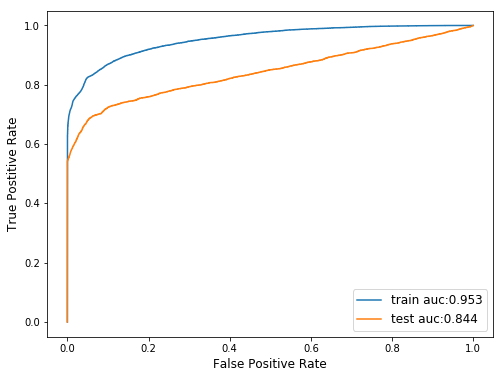

In [39]:
#plt
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(train_fpr, train_tpr, label = 'train auc:' + str(train_auc))
ax.plot(test_fpr, test_tpr, label = 'test auc:' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize = 12)
ax.set_ylabel('True Postitive Rate', fontsize = 12)
ax.legend(fontsize = 12)
plt.show()

In [41]:
clf = GradientBoostingRegressor(verbose=10)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0764           11.19s
         2           0.0693           12.79s
         3           0.0635           11.96s
         4           0.0589           11.39s
         5           0.0551           11.36s
         6           0.0521           11.30s
         7           0.0496           11.10s
         8           0.0476           11.36s
         9           0.0460           11.19s
        10           0.0447           11.04s
        11           0.0436           10.78s
        12           0.0427           10.52s
        13           0.0420           10.53s
        14           0.0415           10.40s
        15           0.0410           10.17s
        16           0.0406           10.10s
        17           0.0403            9.97s
        18           0.0401            9.84s
        19           0.0399            9.67s
        20           0.0397            9.42s
        21           0.0396            9.27s
        2

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=10, warm_start=False)

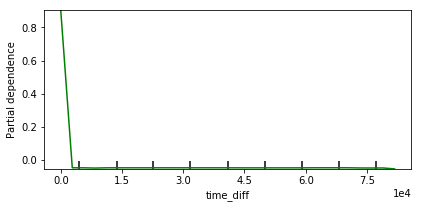

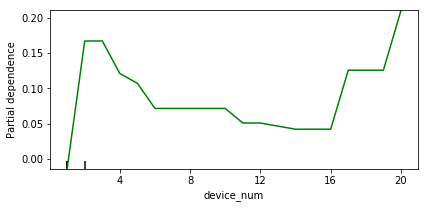

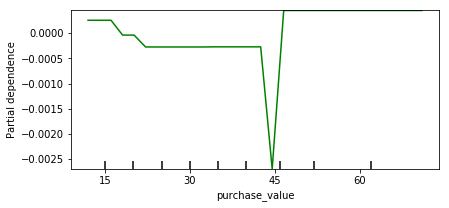

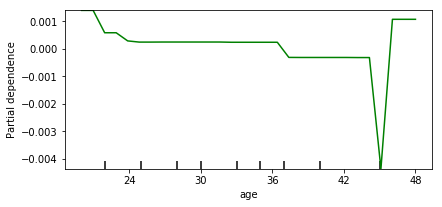

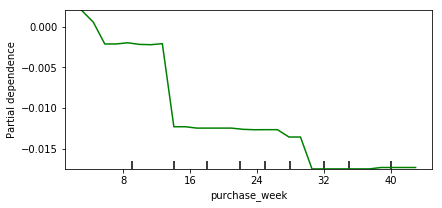

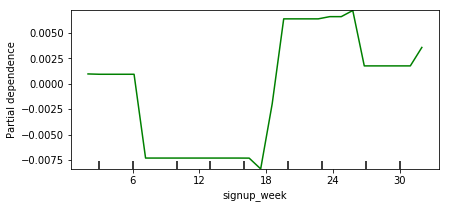

In [42]:
names = X_train.columns
for jj in range(0,6):
    features = indices[jj:(jj+1)]
    fig, axx = plot_partial_dependence(clf, X_train, features, feature_names=names, n_jobs=3, grid_resolution=30)
    #plt.subplots_adjust(left=0.2, top=0.9)